In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import os
import sys
import glob
import re
import pickle
import random

import wave
import librosa as lb
import librosa.display as lbd
from python_speech_features import *
import soundfile as sf
import io
from IPython.display import Audio

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub
import ast

2025-07-28 01:52:07.253758: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-28 01:52:07.268054: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-28 01:52:07.394304: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-28 01:52:07.499108: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753647727.585033    3775 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753647727.61

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense, Embedding, Dropout, Flatten, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(device)

cpu


In [5]:
from sklearn.model_selection import train_test_split

## Download the dataset

In [6]:
df = pd.read_csv('audio_features.csv')
df.head()

,Participant_ID,Gender,PHQ_Binary,PHQ_Score,Audio_Path,Transcript,Features
0,300,male,0,2,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,[[[ 0.45782435 -0.16789621 -0.42220274 -0.1034...
1,301,male,0,3,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,[[[-7.44836628e-01 1.56986952e-01 4.20653224...
2,302,male,0,4,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,[[[-8.32171142e-02 5.00409603e-01 1.96363077...
3,303,female,0,0,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,[[[-0.10374418 0.43084466 0.03568973 0.1818...
4,304,female,0,6,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,[[[ 3.31244320e-01 -2.29787588e-01 2.21745208...


In [7]:
df_b = pd.read_csv('audio_balanced.csv')
df_b.head(10)

,Participant_ID,Gender,PHQ_Binary,PHQ_Score,Audio_Path,Transcript,Features
0,300,male,0,2,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,[[[ 0.45782435 -0.16789621 -0.42220274 -0.1034...
1,301,male,0,3,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,[[[-7.44836628e-01 1.56986952e-01 4.20653224...
2,302,male,0,4,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,[[[-8.32171142e-02 5.00409603e-01 1.96363077...
3,303,female,0,0,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,[[[-0.10374418 0.43084466 0.03568973 0.1818...
4,304,female,0,6,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,[[[ 3.31244320e-01 -2.29787588e-01 2.21745208...
5,305,male,0,7,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,[[[-0.38563088 -0.16254309 -0.6587334 0.2684...
6,306,female,0,0,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,[[[ 0.36333096 -0.5662466 -0.40498564 -0.1287...
7,307,female,0,4,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,[[[ 0.27195254 -0.21250738 -0.11973132 -0.3759...
8,308,female,1,22,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,[[[-2.44443923e-01 1.61619589e-01 8.81917104...
9,308,female,1,22,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,[[[-2.44443923e-01 1.61619589e-01 8.81917104...


In [8]:
df_77 = pd.read_csv('audio_balanced_77.csv')
df_77.head(10)

,Participant_ID,Gender,PHQ_Binary,PHQ_Score,Audio_Path,Transcript,Features
0,348,female,1,20,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,[[[-3.40598673e-01 9.33712721e-02 -1.90273777...
1,489,male,0,3,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,[[[ 2.63704985e-01 -3.17334503e-01 4.46398631...
2,355,male,1,10,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,[[[-3.79513204e-01 -1.34675205e-01 -2.58812875...
3,429,male,0,1,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,[[[-0.01984847 0.4493386 -0.4008954 -0.1001...
4,453,male,1,17,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,[[[-0.29727948 0.03617591 -0.35105297 -0.0657...
5,377,female,1,16,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,[[[ 6.47765696e-02 -4.00447190e-01 2.20816001...
6,367,male,1,19,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,[[[-2.13402376e-01 -1.64476186e-01 -3.62280548...
7,308,female,1,22,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,[[[-2.44443923e-01 1.61619589e-01 8.81917104...
8,439,female,0,1,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,[[[-0.37199613 0.27222198 0.11051914 -0.2091...
9,490,male,0,2,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,[[[ 1.92603886e-01 2.70704538e-01 -6.84871078...


In [9]:
train_df_balanced = pd.read_csv('train_balanced.csv')
test_df_balanced = pd.read_csv('test_balanced.csv')


In [10]:
df_bdown = pd.read_csv('audio_balanced_downsampled.csv')
df_bdown.head()

,Participant_ID,Gender,PHQ_Binary,PHQ_Score,Audio_Path,Transcript,Features
0,467,male,0,0,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,[[[ 0.28526664 0.09967513 0.00799948 0.4890...
1,337,female,1,10,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,[[[-9.22581181e-02 1.32208377e-01 -4.22364444...
2,469,female,0,3,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,[[[ 2.01293193e-02 1.62733659e-01 7.91895017...
3,376,female,1,12,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,[[[-0.2775235 0.07668287 -0.00362719 -0.1866...
4,359,male,1,13,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,[[[-0.06512055 -0.02693447 0.11681422 0.2453...


In [11]:
train_df_bdown = pd.read_csv('train_balanced_downsampled.csv')
test_df_bdown = pd.read_csv('test_balanced_downsampled.csv')

In [12]:
# print table for sizes of df, df_balanced, df_balanced_downsampled, df_77, train_df_balanced, test_df_balanced, train_df_bdown, test_df_bdown
sizes_table = pd.DataFrame({
    'DataFrame': ['df', 'df_balanced', 'df_balanced_downsampled', 'df_77', 'train_df_balanced', 'test_df_balanced', 'train_df_bdown', 'test_df_bdown'],
    'No. of Samples': [len(df), len(df_b), len(df_bdown), len(df_77), len(train_df_balanced), len(test_df_balanced), len(train_df_bdown), len(test_df_bdown)]
})

sizes_table = sizes_table.set_index('DataFrame')
sizes_table = sizes_table.reset_index()
sizes_table = sizes_table.style.set_properties(**{'text-align': 'left'})
sizes_table = sizes_table.set_table_attributes('class="table table-striped"')
sizes_table = sizes_table.set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}])
sizes_table

,DataFrame,No. of Samples
0,df,196
1,df_balanced,306
2,df_balanced_downsampled,86
3,df_77,154
4,train_df_balanced,232
5,test_df_balanced,74
6,train_df_bdown,64
7,test_df_bdown,22


## Train Test Split

In the model:
1. training data = mfcc  
2. test data = binary score

The train test split will be done in 5 ways:
1. train_test_split from balanced df with 0.8 train and 0.2 test - upsampled
2. train_test_split from balanced df_77 with 0.8 train and 0.2 test
3. preset train and test set - upsampled
4. train_test_split from balanced df with 0.8 train and 0.2 test - downsampled
5. preset train and test set - downsampled

### Upsampled

In [13]:
print(type(df_b['Features'].iloc[0]))
print(df_b['Features'].iloc[0])

<class 'str'>
[[[ 0.45782435 -0.16789621 -0.42220274 -0.10343518  0.40424666
    0.10950082 -0.10788921 -0.24158162 -0.16802783  0.28292382
    0.119771    0.12153898  0.0592424   0.3513849   0.36848354
    0.12889512  0.12525885  0.00962402  0.26556757  0.06719269
    0.02860339 -0.3028025  -0.14111695  0.07667189  0.00655118
   -0.09356288  0.16502567  0.21336699 -0.25145373 -0.14807656
   -0.06370846  0.22107553  0.1097368  -0.26070297  0.00928994
    0.0954789  -0.13317229  0.04311724  0.1640533   0.02572896
   -0.00282368  0.15992478 -0.42556697 -0.3697348  -0.04071535
   -0.17419668  0.20983545  0.17101762 -0.10762207 -0.18215209
    0.20145273  0.12870961  0.0651093   0.26367217  0.0336712
    0.21048628  0.21782425 -0.31287846  0.49279523  0.0361019
   -0.01474101 -0.11652218  0.38157347  0.17886752 -0.17460082
    0.07714463 -0.25989217  0.07448899  0.19171417 -0.15632713
   -0.51748157  0.3818591  -0.06637437  0.10917307  0.41810808
   -0.504725    0.14256641  0.15922032 -0.0

In [14]:
# Convert the string into numeric array
if type(df_b['Features'].iloc[0]) == str:
    # Replace newlines and brackets, then convert to numpy array
    df_b['Features'] = df_b['Features'].apply(lambda x: np.fromstring(x.replace('\n', ' ').replace('[', '').replace(']', ''), sep=' '))

# Now convert to stacked array
X = np.stack(df_b['Features'].values)

# Sanity check: Make sure you have 256 features
print("X shape before reshape:", X.shape)

# Reshape for GRU: (samples, time_steps=1, features=256)
X = X.reshape(-1, 1, 256)

# Labels
y = df_b['PHQ_Binary'].values

X shape before reshape: (306, 256)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=44)
print("Train and Test Split for Balanced:" f"{X_train.shape}, {X_test.shape}, {y_train.shape}, {y_test.shape}")

Train and Test Split for Balanced:(244, 1, 256), (62, 1, 256), (244,), (62,)


In [16]:
df_77['Features'] = df_77['Features'].apply(lambda x: np.fromstring(x.replace('\n', ' ').replace('[', '').replace(']', ''), sep=' '))
X_77 = np.stack(df_77['Features'].values)
print("X_77 shape before reshape:", X_77.shape)
X_77 = X_77.reshape(-1, 1, 256)
y_77 = df_77['PHQ_Binary'].values

X_77 shape before reshape: (154, 256)


In [17]:
X_train77, X_test77, y_train77, y_test77 = train_test_split(X_77, y_77, test_size=0.2, random_state=44)
print("Train and Test Split for Balanced 77:" f"{X_train77.shape}, {X_test77.shape}, {y_train77.shape}, {y_test77.shape}")

Train and Test Split for Balanced 77:(123, 1, 256), (31, 1, 256), (123,), (31,)


In [18]:
train_df_balanced['Features'] = train_df_balanced['Features'].apply(lambda x: np.fromstring(x.replace('\n', ' ').replace('[', '').replace(']', ''), sep=' '))
X_train2 = np.stack(train_df_balanced['Features'].values)
print("X_train2 shape before reshape:", X_train2.shape)
X_train2 = X_train2.reshape(-1, 1, 256)
y_train2 = train_df_balanced['PHQ_Binary'].values

test_df_balanced['Features'] = test_df_balanced['Features'].apply(lambda x: np.fromstring(x.replace('\n', ' ').replace('[', '').replace(']', ''), sep=' '))
X_test2 = np.stack(test_df_balanced['Features'].values)
print("X_test2 shape before reshape:", X_test2.shape)
X_test2 = X_test2.reshape(-1, 1, 256)
y_test2 = test_df_balanced['PHQ_Binary'].values


X_train2 shape before reshape: (232, 256)
X_test2 shape before reshape: (74, 256)


In [19]:
print("Balancing train test separately: ")
print(X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape)

Balancing train test separately: 
(232, 1, 256) (74, 1, 256) (232,) (74,)


### Downsampled

In [20]:
df_bdown['Features'] = df_bdown['Features'].apply(lambda x: np.fromstring(x.replace('\n', ' ').replace('[', '').replace(']', ''), sep=' '))
X_d = np.stack(df_bdown['Features'].values)
print("X_d shape before reshape:", X_d.shape)
X_d = X_d.reshape(-1, 1, 256)
# X_d = X_d.reshape(-1, 16, 16)
y_d = df_bdown['PHQ_Binary'].values 

X_d shape before reshape: (86, 256)


In [21]:
Xd_train, Xd_test, yd_train, yd_test = train_test_split(X_d, y_d, test_size=0.2, random_state=44)
print("Train and Test Split for Downsampled:" f"{Xd_train.shape}, {Xd_test.shape}, {yd_train.shape}, {yd_test.shape}")

Train and Test Split for Downsampled:(68, 1, 256), (18, 1, 256), (68,), (18,)


In [22]:
train_df_bdown['Features'] = train_df_bdown['Features'].apply(lambda x: np.fromstring(x.replace('\n', ' ').replace('[', '').replace(']', ''), sep=' '))
Xd_train2 = np.stack(train_df_bdown['Features'].values)
print("Xd_train2 shape before reshape:", Xd_train2.shape)
Xd_train2 = Xd_train2.reshape(-1, 1, 256)
yd_train2 = train_df_bdown['PHQ_Binary'].values 

test_df_bdown['Features'] = test_df_bdown['Features'].apply(lambda x: np.fromstring(x.replace('\n', ' ').replace('[', '').replace(']', ''), sep=' '))
Xd_test2 = np.stack(test_df_bdown['Features'].values)
print("Xd_test2 shape before reshape:", Xd_test2.shape)
Xd_test2 = Xd_test2.reshape(-1, 1, 256)
yd_test2 = test_df_bdown['PHQ_Binary'].values


Xd_train2 shape before reshape: (64, 256)
Xd_test2 shape before reshape: (22, 256)


In [23]:
print("Balancing train test separately for downsampled: ")
print(Xd_train2.shape, Xd_test2.shape, yd_train2.shape, yd_test2.shape)

Balancing train test separately for downsampled: 
(64, 1, 256) (22, 1, 256) (64,) (22,)


# Model Building and Architecture

The models used are:
1. GRU 
2. BiLSTM

Number of epochs will be 10, 50 and 100

Dataset used:
1. Upsampled balanced dataset
2. 77 of each class
3. preset train and test set - upsampled
4. Downsampled balanced dataset
5. Preset train and test set - downsampled

## GRU

| #GRU Layers | #Dense Layers | INput Shape | Regularization| Dataset |
| ------------ | ------------- | ----------- | -------------- | -------------- |
| 64 | 32 | (1, 256) |  None | Upsampled, 77, Downsampled, Preset |
| 32 | 16 | (1, 256) |  None | Upsampled, 77, Downsampled, Preset |
| 64 | 32 | (16, 16) |  None | Upsampled, 77, Downsampled, Preset |
| 32 | 16 | (16, 16) |  None | Upsampled, 77, Downsampled, Preset |

### GRU 64, 32, (1, 256), None

In [24]:
model = Sequential()
model.add(GRU(64, input_shape=(1, 256), return_sequences=False))  # single time step
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

2025-07-28 01:52:11.310913: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,937 (249.75 KB)

 Trainable params: 63,937 (249.75 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# plot graph of accuracy and loss over time in same figure
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Model Accuracy and Loss')
    plt.xlabel('Epochs')

In [26]:
# evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int)

    accuracy = accuracy_score(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")    
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    

In [27]:
# folder to save nodels
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

#### 1. Upsampled Balanced Dataset 

In [28]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

history = model.fit(X_train, y_train, epochs=10, batch_size=4, validation_data=(X_test, y_test))

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5977 - loss: 0.6804 - val_accuracy: 0.6774 - val_loss: 0.6507
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7747 - loss: 0.5932 - val_accuracy: 0.7258 - val_loss: 0.5919
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8520 - loss: 0.4946 - val_accuracy: 0.7742 - val_loss: 0.5359
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9232 - loss: 0.3627 - val_accuracy: 0.7903 - val_loss: 0.4669
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9736 - loss: 0.2304 - val_accuracy: 0.7903 - val_loss: 0.4145
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9665 - loss: 0.1532 - val_accuracy: 0.8387 - val_loss: 0.4054
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9883 - loss: 0.0942 - val_accuracy: 0.8710 - val_loss: 0.3878
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0643 - val_accuracy: 0.8710 - val_loss:

In [29]:
evaluate_model(model, X_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Accuracy: 0.8710
Precision: 0.7895
Recall: 1.0000
F1 Score: 0.8824


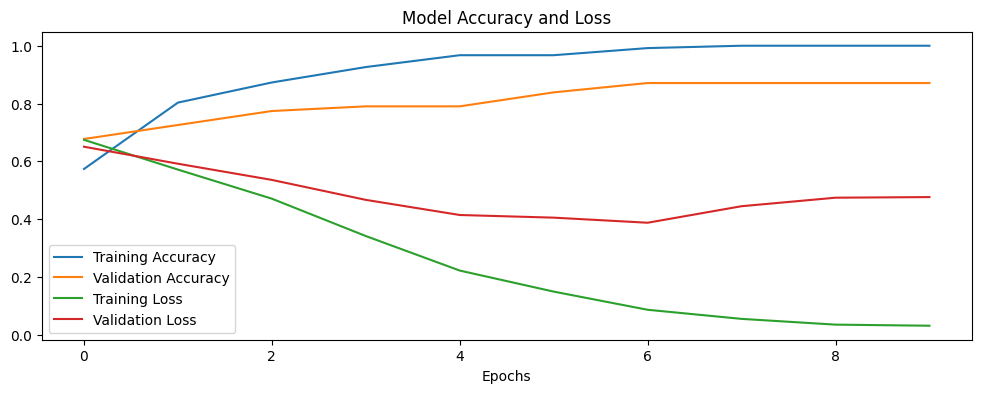

In [30]:
plot_history(history)   
model.save('saved_models/gru_10_1.keras')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 64)             │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,937 (249.75 KB)

 Trainable params: 63,937 (249.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5920 - loss: 0.6850 - val_accuracy: 0.5968 - val_loss: 0.6534
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7045 - loss: 0.6061 - val_accuracy: 0.6935 - val_loss: 0.6049
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9092 - loss: 0.4853 - val_accuracy: 0.8065 - val_loss: 0.5310
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9425 - loss: 0.3601 - val_accuracy: 0.8387 - val_loss: 0.4748
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9602 - loss: 0.2357 - val_accuracy: 0.8226 - val_loss: 0.4295
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9870 - loss: 0.1667 - val_accuracy: 0.8226 - val_loss: 0.4042
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9874 - loss: 0.0936 - val_accuracy: 0.8387 - val_loss: 0.4173
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9835 - loss: 0.0804 - val_accuracy: 0.8710 - val_loss:

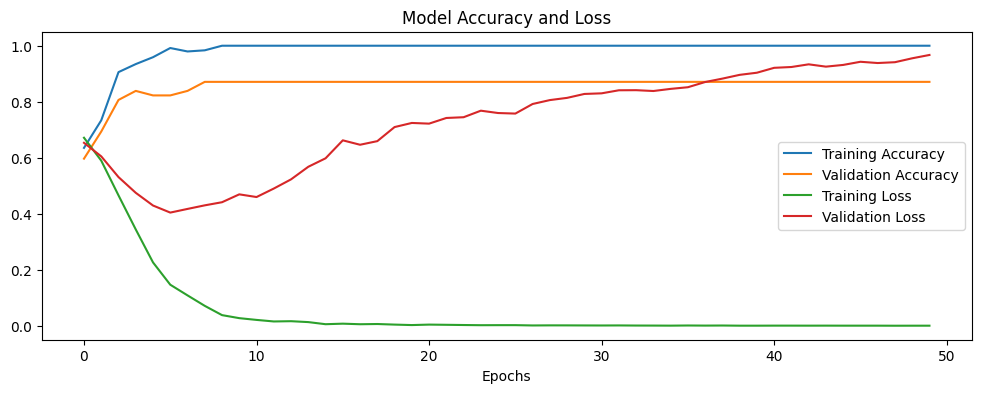

In [31]:
model = Sequential()
model.add(GRU(64, input_shape=(1, 256), return_sequences=False))  # single time step
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

epochs = 50
history = model.fit(X_train, y_train, epochs=epochs, batch_size=4, validation_data=(X_test, y_test))

evaluate_model(model, X_test, y_test)
plot_history(history)

model.save('saved_models/gru_model_b10_epochs50.keras')

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 64)             │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,937 (249.75 KB)

 Trainable params: 63,937 (249.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5058 - loss: 0.6833 - val_accuracy: 0.6774 - val_loss: 0.6538
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8210 - loss: 0.6047 - val_accuracy: 0.7097 - val_loss: 0.6086
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8225 - loss: 0.5151 - val_accuracy: 0.6935 - val_loss: 0.5490
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9366 - loss: 0.3752 - val_accuracy: 0.7581 - val_loss: 0.4847
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9514 - loss: 0.2770 - val_accuracy: 0.7742 - val_loss: 0.4375
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9795 - loss: 0.1584 - val_accuracy: 0.7903 - val_loss: 0.4127
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9916 - loss: 0.1224 - val_accuracy: 0.8226 - val_loss: 0.3977
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0847 - val_accuracy: 0.8226 - v

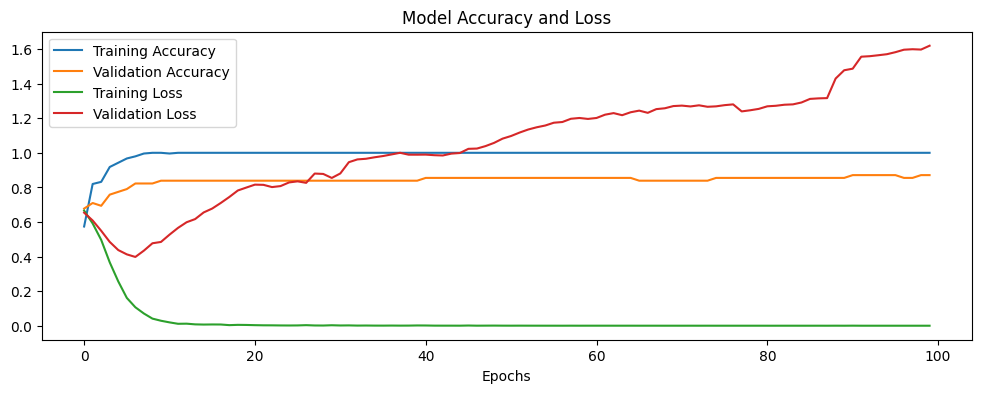

In [32]:
model = Sequential()
model.add(GRU(64, input_shape=(1, 256), return_sequences=False))  # single time step
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

epochs = 100
history = model.fit(X_train, y_train, epochs=epochs, batch_size=4, validation_data=(X_test, y_test))

evaluate_model(model, X_test, y_test)
plot_history(history)
model.save('saved_models/gru_model_b_epochs100.keras')

#### 2. 77 of each class

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                     │ (None, 64)             │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,937 (249.75 KB)

 Trainable params: 63,937 (249.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4559 - loss: 0.6925 - val_accuracy: 0.6129 - val_loss: 0.6829
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6502 - loss: 0.6521 - val_accuracy: 0.7419 - val_loss: 0.6685
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8320 - loss: 0.5898 - val_accuracy: 0.6774 - val_loss: 0.6455
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8525 - loss: 0.5417 - val_accuracy: 0.6774 - val_loss: 0.6254
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9532 - loss: 0.4460 - val_accuracy: 0.7097 - val_loss: 0.5935
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9747 - loss: 0.3546 - val_accuracy: 0.6774 - val_loss: 0.5739
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9578 - loss: 0.2706 - val_accuracy: 0.7742 - val_loss: 0.5612
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9861 - loss: 0.2071 - val_accuracy: 0.7742 - val_loss:

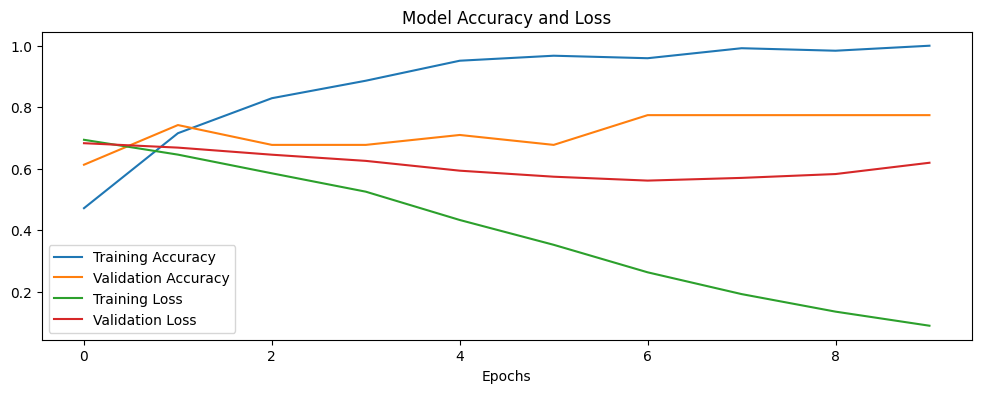

In [33]:
model = Sequential()
model.add(GRU(64, input_shape=(1, 256), return_sequences=False))  # single time step
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

epochs = 10
# on df_77
history = model.fit(X_train77, y_train77, epochs=epochs, batch_size=4, validation_data=(X_test77, y_test77))
evaluate_model(model, X_test77, y_test77)
plot_history(history)
# save the model
model.save('saved_models/gru_model_b77_epochs10.keras')

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 64)             │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,937 (249.75 KB)

 Trainable params: 63,937 (249.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4389 - loss: 0.6976 - val_accuracy: 0.5484 - val_loss: 0.6839
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7455 - loss: 0.6322 - val_accuracy: 0.5806 - val_loss: 0.6638
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8163 - loss: 0.5688 - val_accuracy: 0.6129 - val_loss: 0.6446
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9149 - loss: 0.5057 - val_accuracy: 0.5806 - val_loss: 0.6333
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8727 - loss: 0.4324 - val_accuracy: 0.6129 - val_loss: 0.6080
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9519 - loss: 0.3606 - val_accuracy: 0.7419 - val_loss: 0.5707
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9842 - loss: 0.2772 - val_accuracy: 0.8065 - val_loss: 0.5581
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9846 - loss: 0.1991 - val_accuracy: 0.8065 - val_loss:

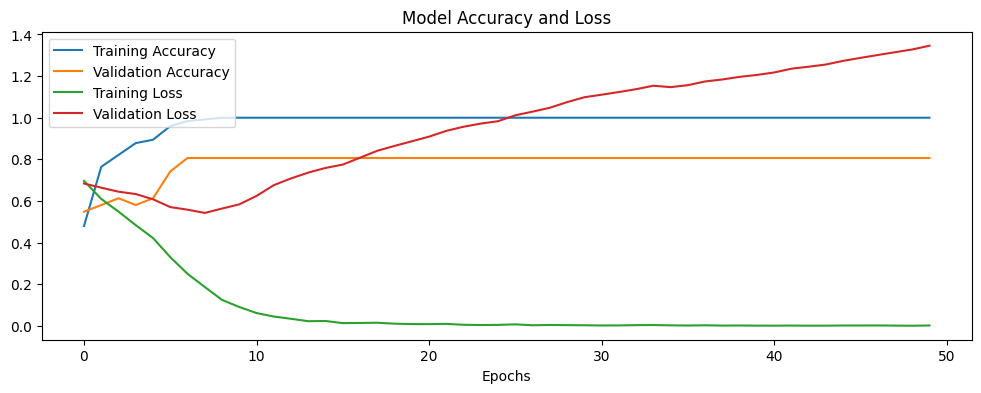

In [34]:
model = Sequential()
model.add(GRU(64, input_shape=(1, 256), return_sequences=False))  # single time step
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

epochs = 50
history = model.fit(X_train77, y_train77, epochs=epochs, batch_size=4, validation_data=(X_test77, y_test77))
evaluate_model(model, X_test77, y_test77)
plot_history(history)
model.save('saved_models/gru_model_b77_epochs50.keras')

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_5 (GRU)                     │ (None, 64)             │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,937 (249.75 KB)

 Trainable params: 63,937 (249.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4446 - loss: 0.6948 - val_accuracy: 0.5484 - val_loss: 0.6924
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7126 - loss: 0.6326 - val_accuracy: 0.5806 - val_loss: 0.6743
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7684 - loss: 0.5790 - val_accuracy: 0.6129 - val_loss: 0.6581
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8840 - loss: 0.5086 - val_accuracy: 0.6774 - val_loss: 0.6280
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9569 - loss: 0.4199 - val_accuracy: 0.7097 - val_loss: 0.5950
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9491 - loss: 0.3515 - val_accuracy: 0.7742 - val_loss: 0.5632
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9968 - loss: 0.2803 - val_accuracy: 0.7742 - val_loss: 0.5402
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9826 - loss: 0.1697 - val_accuracy: 0.7742 - v

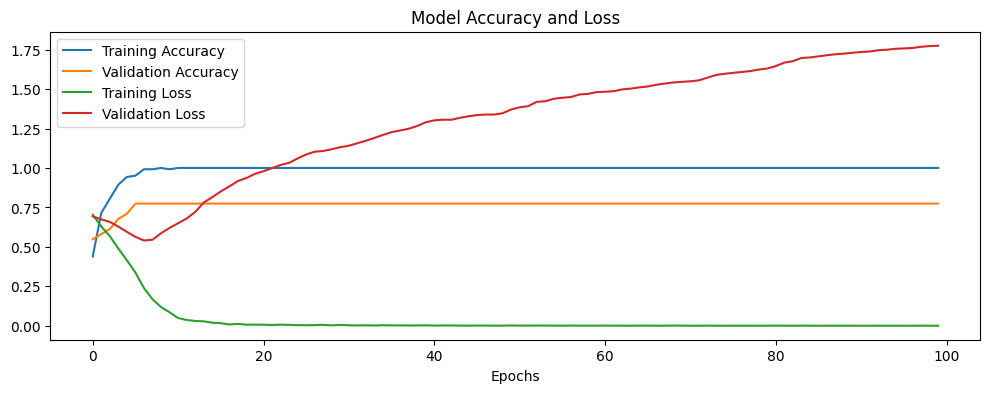

In [35]:
model = Sequential()
model.add(GRU(64, input_shape=(1, 256), return_sequences=False))  # single time step
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

epochs = 100
history = model.fit(X_train77, y_train77, epochs=epochs, batch_size=4, validation_data=(X_test77, y_test77))
evaluate_model(model, X_test77, y_test77)
plot_history(history)
model.save('saved_models/gru_model_b77_epochs100.keras')

#### 3. Preset train and test set - upsampled


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_6 (GRU)                     │ (None, 64)             │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,937 (249.75 KB)

 Trainable params: 63,937 (249.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5498 - loss: 0.6828 - val_accuracy: 0.5270 - val_loss: 0.6816
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7712 - loss: 0.5804 - val_accuracy: 0.6351 - val_loss: 0.6834
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8610 - loss: 0.4827 - val_accuracy: 0.5946 - val_loss: 0.7112
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9086 - loss: 0.3423 - val_accuracy: 0.5541 - val_loss: 0.7986
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9824 - loss: 0.2164 - val_accuracy: 0.5676 - val_loss: 1.0317
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9684 - loss: 0.1400 - val_accuracy: 0.5270 - val_loss: 1.2584
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0701 - val_accuracy: 0.5541 - val_loss: 1.5155
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9927 - loss: 0.0484 - val_accuracy: 0.5405 - val_loss:

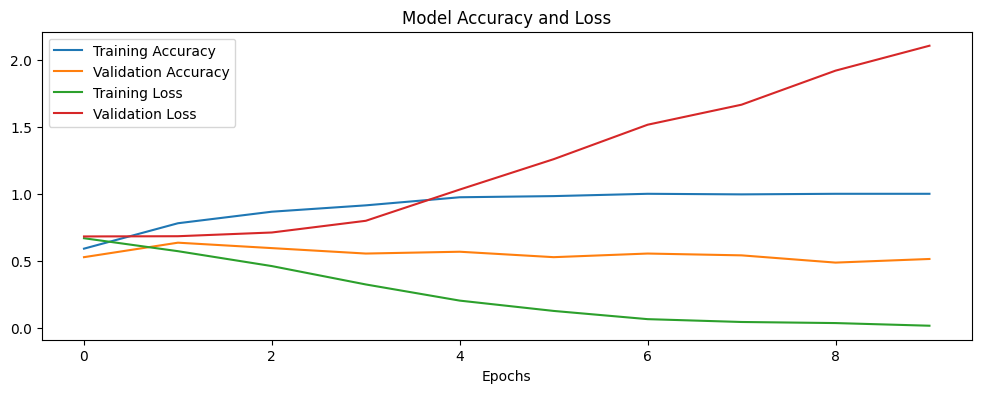

In [36]:
model = Sequential()
model.add(GRU(64, input_shape=(1, 256), return_sequences=False))  # single time step
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

epochs = 10
history = model.fit(X_train2, y_train2, epochs=epochs, batch_size=4, validation_data=(X_test2, y_test2))
evaluate_model(model, X_test2, y_test2)
plot_history(history)
model.save('saved_models/gru_model_b2_epochs10.keras')

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_7 (GRU)                     │ (None, 64)             │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,937 (249.75 KB)

 Trainable params: 63,937 (249.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5495 - loss: 0.6828 - val_accuracy: 0.4839 - val_loss: 0.7047
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6832 - loss: 0.6468 - val_accuracy: 0.5161 - val_loss: 0.6831
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7443 - loss: 0.5916 - val_accuracy: 0.5161 - val_loss: 0.6545
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9032 - loss: 0.4883 - val_accuracy: 0.5806 - val_loss: 0.6327
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8858 - loss: 0.4591 - val_accuracy: 0.6452 - val_loss: 0.6083
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9577 - loss: 0.3423 - val_accuracy: 0.7419 - val_loss: 0.5778
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9675 - loss: 0.2769 - val_accuracy: 0.7419 - val_loss: 0.5704
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9838 - loss: 0.2132 - val_accuracy: 0.7742 - val_loss

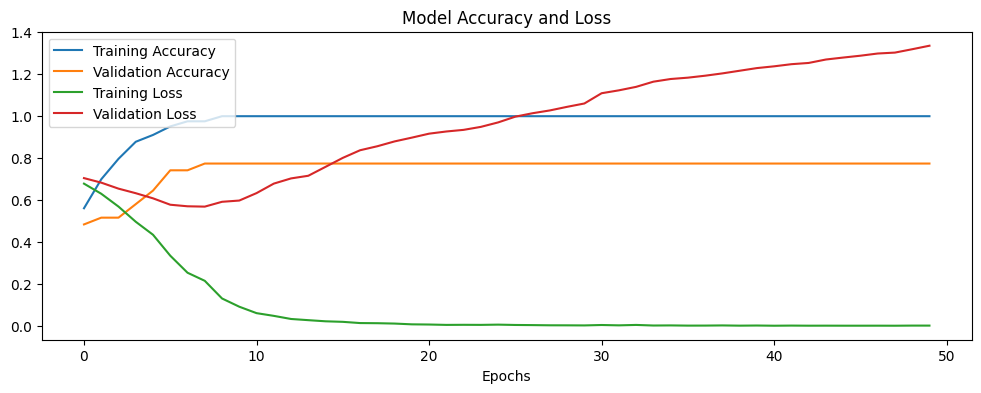

In [38]:
model = Sequential()
model.add(GRU(64, input_shape=(1, 256), return_sequences=False))  # single time step
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

epochs = 50
history = model.fit(X_train77, y_train77, epochs=epochs, batch_size=
4, validation_data=(X_test77, y_test77))
evaluate_model(model, X_test77, y_test77)
plot_history(history)
model.save('saved_models/gru_model_b77_epochs50.keras')

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_8 (GRU)                     │ (None, 64)             │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,937 (249.75 KB)

 Trainable params: 63,937 (249.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4738 - loss: 0.7019 - val_accuracy: 0.6774 - val_loss: 0.6768
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6990 - loss: 0.6124 - val_accuracy: 0.7097 - val_loss: 0.6560
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8713 - loss: 0.5587 - val_accuracy: 0.7097 - val_loss: 0.6242
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8926 - loss: 0.4809 - val_accuracy: 0.7419 - val_loss: 0.5857
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9087 - loss: 0.4203 - val_accuracy: 0.7419 - val_loss: 0.5376
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9543 - loss: 0.3275 - val_accuracy: 0.7742 - val_loss: 0.5147
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9821 - loss: 0.2425 - val_accuracy: 0.8065 - val_loss: 0.4858
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9584 - loss: 0.1912 - val_accuracy: 0.8065 - v

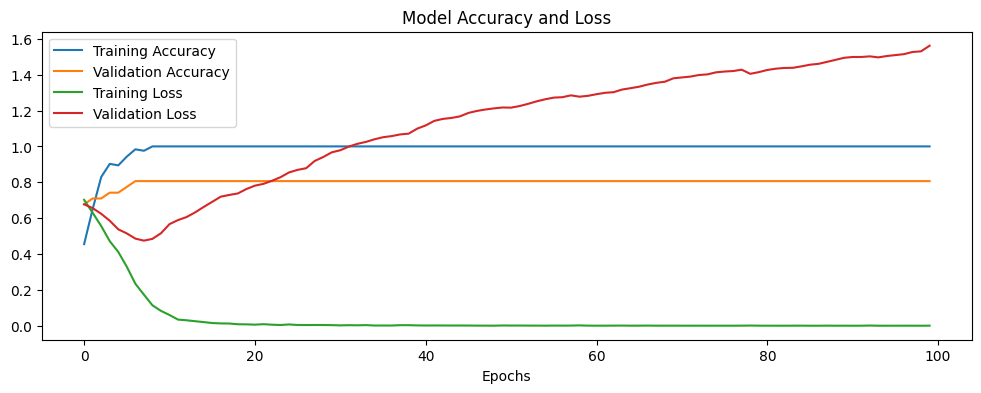

In [39]:
model = Sequential()
model.add(GRU(64, input_shape=(1, 256), return_sequences=False))  # single time step
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

epochs = 100
history = model.fit(X_train77, y_train77, epochs=epochs, batch_size=4, validation_data=(X_test77, y_test77))
evaluate_model(model, X_test77, y_test77)
plot_history(history)

#### 4. Downsampled Balanced Dataset

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_9 (GRU)                     │ (None, 64)             │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,937 (249.75 KB)

 Trainable params: 63,937 (249.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.4572 - loss: 0.6961 - val_accuracy: 0.2778 - val_loss: 0.7148
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5827 - loss: 0.6796 - val_accuracy: 0.2778 - val_loss: 0.7146
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6989 - loss: 0.6600 - val_accuracy: 0.2222 - val_loss: 0.7150
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6815 - loss: 0.6596 - val_accuracy: 0.2222 - val_loss: 0.7153
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7066 - loss: 0.6423 - val_accuracy: 0.2222 - val_loss: 0.7156
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7370 - loss: 0.6385 - val_accuracy: 0.2222 - val_loss: 0.7156
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7439 - loss: 0.6207 - val_accuracy: 0.2778 - val_loss: 0.7166
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8298 - loss: 0.6094 - val_accuracy: 0.2778 - val_loss: 0.7183


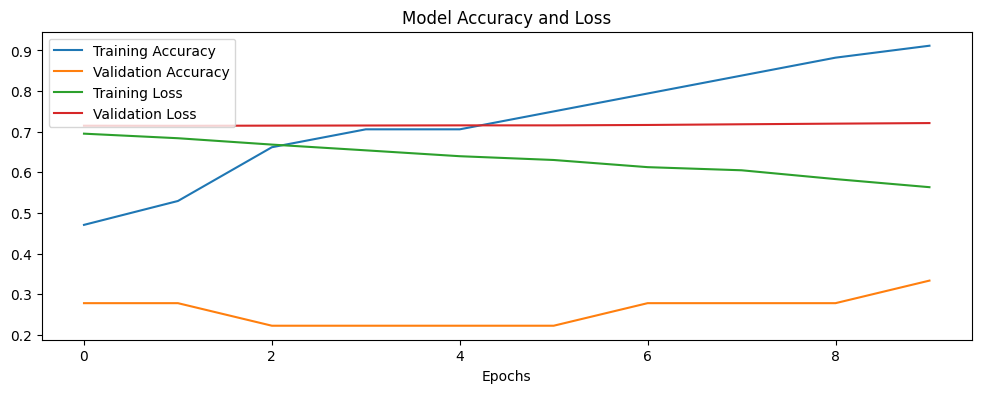

In [40]:
model = Sequential()
model.add(GRU(64, input_shape=(1, 256), return_sequences=False))  # single time step
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

epochs = 10
history = model.fit(Xd_train, yd_train, epochs=epochs, batch_size=16, validation_data=(Xd_test, yd_test))
evaluate_model(model, Xd_test, yd_test)
plot_history(history)
model.save('saved_models/gru_model_d_epochs10.keras')   

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_10 (GRU)                    │ (None, 64)             │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,937 (249.75 KB)

 Trainable params: 63,937 (249.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.6018 - loss: 0.6996 - val_accuracy: 0.5556 - val_loss: 0.6850
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6479 - loss: 0.6459 - val_accuracy: 0.4444 - val_loss: 0.6868
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6595 - loss: 0.6456 - val_accuracy: 0.4444 - val_loss: 0.6892
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6135 - loss: 0.6367 - val_accuracy: 0.4444 - val_loss: 0.6921
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7511 - loss: 0.6236 - val_accuracy: 0.4444 - val_loss: 0.6933
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8861 - loss: 0.5795 - val_accuracy: 0.4444 - val_loss: 0.6949
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8167 - loss: 0.5751 - val_accuracy: 0.3889 - val_loss: 0.6964
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9578 - loss: 0.5421 - val_accuracy: 0.3889 - val_loss: 0.6980


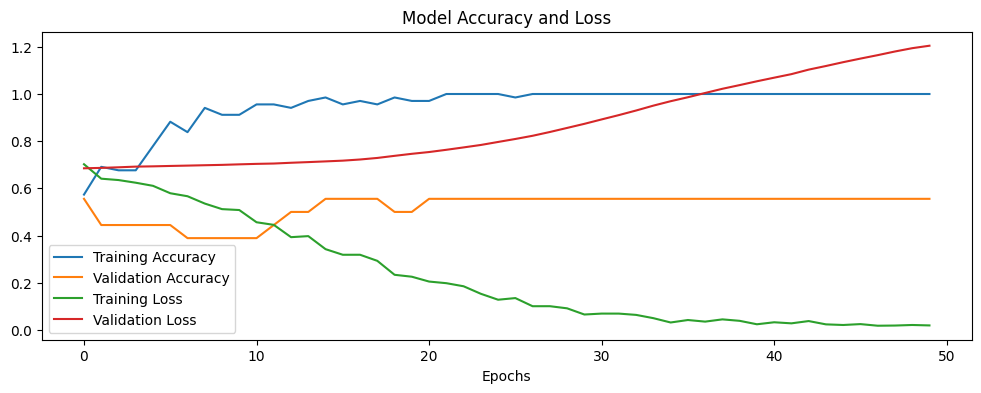

In [41]:
model = Sequential()
model.add(GRU(64, input_shape=(1, 256), return_sequences=False))  # single time step
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

epochs = 50
history = model.fit(Xd_train, yd_train, epochs=epochs, batch_size=16, validation_data=(Xd_test, yd_test))
evaluate_model(model, Xd_test, yd_test)
plot_history(history)
model.save('saved_models/gru_model_d_epochs10.keras')   

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_11 (GRU)                    │ (None, 64)             │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,937 (249.75 KB)

 Trainable params: 63,937 (249.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.4658 - loss: 0.7105 - val_accuracy: 0.5000 - val_loss: 0.7018
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5483 - loss: 0.6767 - val_accuracy: 0.5000 - val_loss: 0.7020
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6393 - loss: 0.6751 - val_accuracy: 0.4444 - val_loss: 0.7024
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7035 - loss: 0.6667 - val_accuracy: 0.4444 - val_loss: 0.7028
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7269 - loss: 0.6481 - val_accuracy: 0.4444 - val_loss: 0.7022
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8121 - loss: 0.6304 - val_accuracy: 0.4444 - val_loss: 0.7019
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8607 - loss: 0.6182 - val_accuracy: 0.4444 - val_loss: 0.7014
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8809 - loss: 0.6064 - val_accuracy: 0.5556 - val_loss:

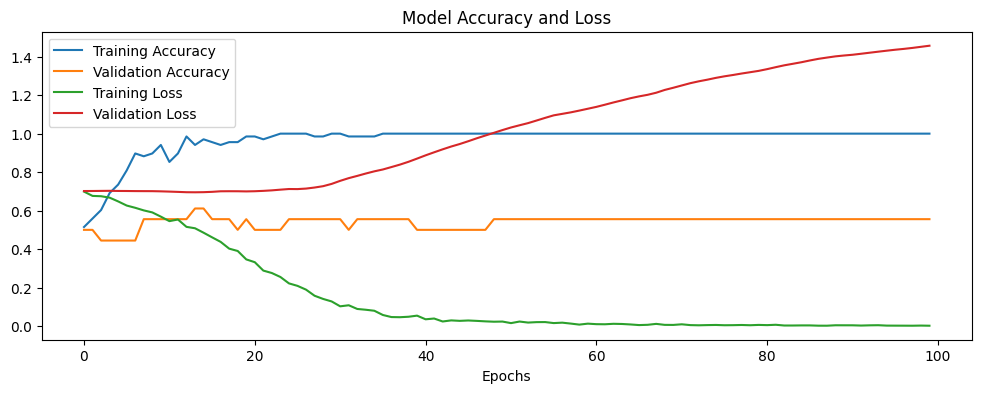

In [42]:
model = Sequential()
model.add(GRU(64, input_shape=(1, 256), return_sequences=False))  # single time step
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

epochs = 100
history = model.fit(Xd_train, yd_train, epochs=epochs, batch_size=16, validation_data=(Xd_test, yd_test))
evaluate_model(model, Xd_test, yd_test)
plot_history(history)
model.save('saved_models/gru_model_d_epochs10.keras')   

In [43]:
# model = Sequential()
# model.add(GRU(32, input_shape=(1, 256), return_sequences=False))  # single time step
# model.add(Dropout(0.3))
# model.add(Dense(16, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(1, activation='sigmoid'))  # binary classification

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()

In [44]:
# epochs = 50
# history = model.fit(Xd_train, yd_train, epochs=epochs, batch_size=16, validation_data=(Xd_test, yd_test))
# evaluate_model(model, Xd_test, yd_test)
# plot_history(history)
# model.save('saved_models/gru_model_d_epochs50.keras')   

In [45]:
# model = Sequential()
# model.add(GRU(64, input_shape=(1, 256), return_sequences=False))  # single time step
# model.add(Dropout(0.3))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(1, activation='sigmoid'))  # binary classification

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()

In [46]:
# epochs = 100
# history = model.fit(Xd_train, yd_train, epochs=epochs, batch_size=16, validation_data=(Xd_test, yd_test))
# evaluate_model(model, Xd_test, yd_test)
# plot_history(history)
# model.save('saved_models/gru_model_d_epochs100.keras') 

#### 5. Preset train and test set - downsampled


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_12 (GRU)                    │ (None, 64)             │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,937 (249.75 KB)

 Trainable params: 63,937 (249.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6777 - loss: 0.6652 - val_accuracy: 0.5000 - val_loss: 0.6971
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5587 - loss: 0.6648 - val_accuracy: 0.5556 - val_loss: 0.6916
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7721 - loss: 0.6006 - val_accuracy: 0.5000 - val_loss: 0.6907
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8545 - loss: 0.5807 - val_accuracy: 0.5556 - val_loss: 0.6884
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8719 - loss: 0.5018 - val_accuracy: 0.5556 - val_loss: 0.6894
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8844 - loss: 0.4810 - val_accuracy: 0.6111 - val_loss: 0.6877
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9842 - loss: 0.4163 - val_accuracy: 0.6667 - val_loss: 0.6910
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9609 - loss: 0.3927 - val_accuracy: 0.6667 - val_loss

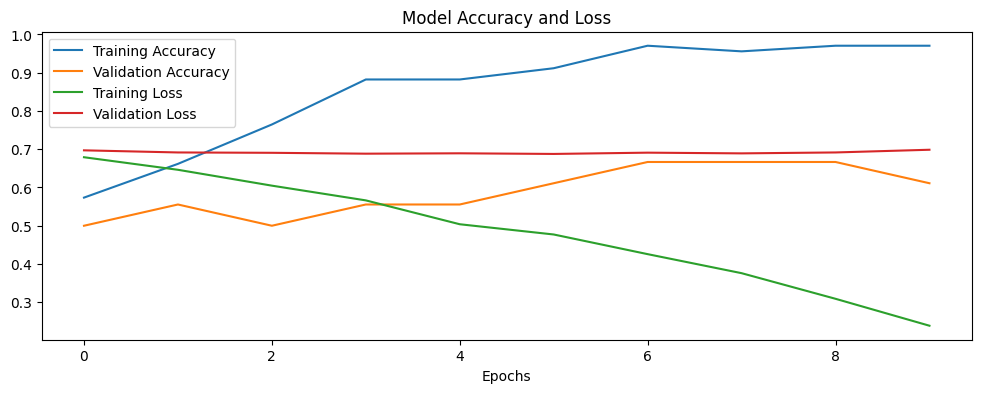

In [47]:
model = Sequential()
model.add(GRU(64, input_shape=(1, 256), return_sequences=False))  # single time step
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

epochs = 10
history = model.fit(Xd_train, yd_train, epochs=epochs, batch_size=4, validation_data=(Xd_test, yd_test))
evaluate_model(model, Xd_test, yd_test)
plot_history(history)
model.save('saved_models/gru_model_d_epochs10.keras')

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_13 (GRU)                    │ (None, 64)             │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,937 (249.75 KB)

 Trainable params: 63,937 (249.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5252 - loss: 0.6946 - val_accuracy: 0.4444 - val_loss: 0.6901
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6966 - loss: 0.6459 - val_accuracy: 0.5556 - val_loss: 0.6925
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7897 - loss: 0.6301 - val_accuracy: 0.5000 - val_loss: 0.6973
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7346 - loss: 0.6078 - val_accuracy: 0.4444 - val_loss: 0.6983
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8828 - loss: 0.5503 - val_accuracy: 0.5000 - val_loss: 0.7071
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9279 - loss: 0.5225 - val_accuracy: 0.4444 - val_loss: 0.7144
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9748 - loss: 0.4350 - val_accuracy: 0.4444 - val_loss: 0.7246
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9519 - loss: 0.4055 - val_accuracy: 0.5000 - val_loss

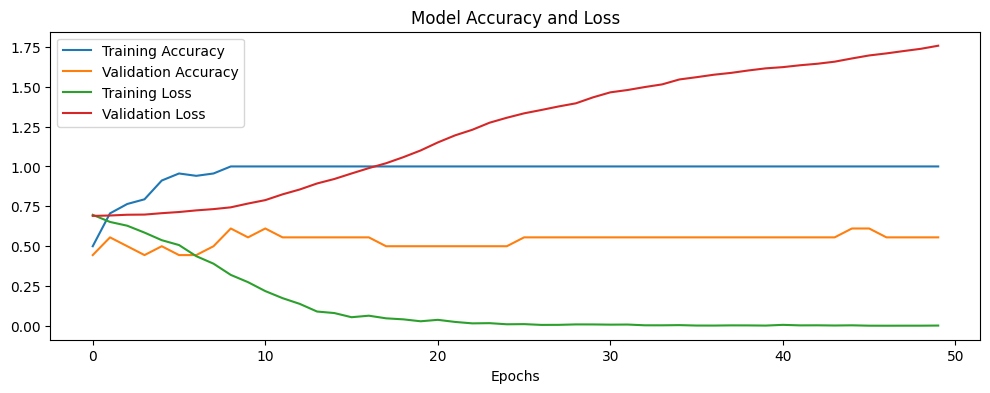

In [48]:
model = Sequential()
model.add(GRU(64, input_shape=(1, 256), return_sequences=False))  # single time step
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

epochs = 50
history = model.fit(Xd_train, yd_train, epochs=epochs, batch_size=4, validation_data=(Xd_test, yd_test))
evaluate_model(model, Xd_test, yd_test)
plot_history(history)
model.save('saved_models/gru_model_d_epochs50.keras')

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_14 (GRU)                    │ (None, 64)             │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,937 (249.75 KB)

 Trainable params: 63,937 (249.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4620 - loss: 0.6951 - val_accuracy: 0.6111 - val_loss: 0.6825
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8034 - loss: 0.6366 - val_accuracy: 0.6667 - val_loss: 0.6816
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8929 - loss: 0.6071 - val_accuracy: 0.5556 - val_loss: 0.6852
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7993 - loss: 0.5821 - val_accuracy: 0.5556 - val_loss: 0.6886
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9423 - loss: 0.5289 - val_accuracy: 0.5000 - val_loss: 0.6923
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9149 - loss: 0.5092 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9283 - loss: 0.4670 - val_accuracy: 0.6111 - val_loss: 0.6961
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9345 - loss: 0.3750 - val_accuracy: 0.6111 - 

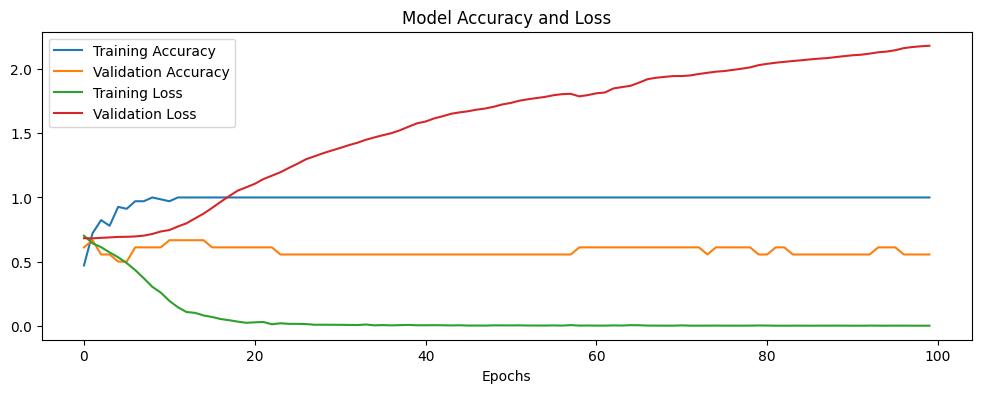

In [49]:
model = Sequential()
model.add(GRU(64, input_shape=(1, 256), return_sequences=False))  # single time step
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

epochs = 100
history = model.fit(Xd_train, yd_train, epochs=epochs, batch_size=4, validation_data=(Xd_test, yd_test))
evaluate_model(model, Xd_test, yd_test)
plot_history(history)
model.save('saved_models/gru_model_d_epochs100.keras')

## BiLSTM


In [59]:
model_bilstm = Sequential()
model_bilstm.add(Bidirectional(LSTM(64, return_sequences=False), input_shape=(1, 256)))  # single time step
model_bilstm.add(Dropout(0.2))
model_bilstm.add(Dense(32, activation='relu'))
model_bilstm.add(Dropout(0.2))
model_bilstm.add(Dense(1, activation='sigmoid'))  # binary classification  

model_bilstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_bilstm.summary()  

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_18                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,513 (658.25 KB)

 Trainable params: 168,513 (658.25 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
# plot graph of accuracy and loss over time
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [61]:
epochs = [10, 50, 100]

Training for 10 epochs


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_19                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,513 (658.25 KB)

 Trainable params: 168,513 (658.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9901 - loss: 0.0420 - val_accuracy: 0.9194 - val_loss: 0.7219
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9986 - loss: 0.0050 - val_accuracy: 0.9194 - val_loss: 0.7691
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.5560e-04 - val_accuracy: 0.9194 - val_loss: 0.8203
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.3068e-04 - val_accuracy: 0.9194 - val_loss: 0.8379
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9194 - val_loss: 0.8411
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.8611e-04 - val_accuracy: 0.9194 - val_loss: 0.8446
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8726e-04 - val_accuracy: 0.9194 - val_loss: 0.8486
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1104e-04 - val_accuracy: 0.9194 - val_

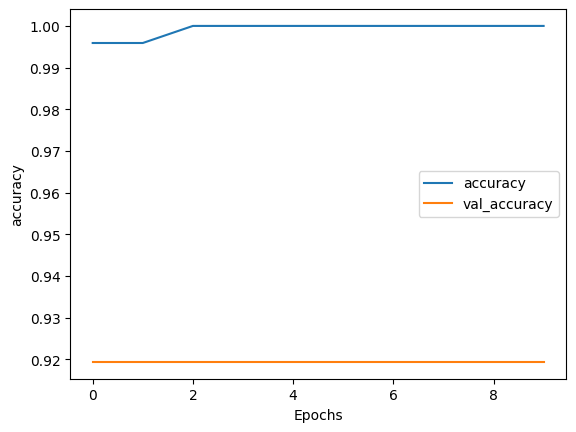

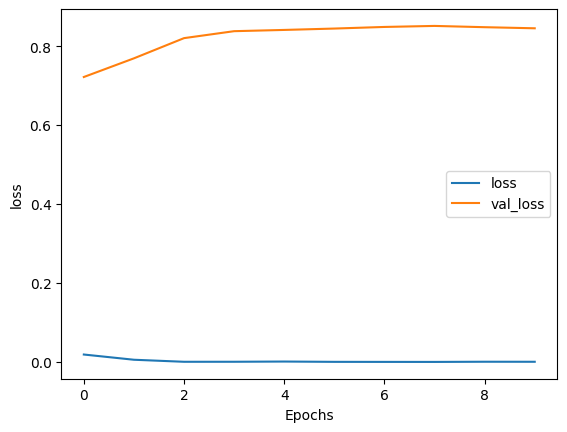

Training for 50 epochs


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_20                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,513 (658.25 KB)

 Trainable params: 168,513 (658.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 2.7889e-04 - val_accuracy: 0.9194 - val_loss: 0.8414
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 5.2891e-04 - val_accuracy: 0.9194 - val_loss: 0.8454
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4909e-04 - val_accuracy: 0.9194 - val_loss: 0.8475
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1418e-04 - val_accuracy: 0.9194 - val_loss: 0.8479
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3707e-04 - val_accuracy: 0.9194 - val_loss: 0.8489
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2324e-04 - val_accuracy: 0.9194 - val_loss: 0.8492
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2536e-04 - val_accuracy: 0.9194 - val_loss: 0.8490
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.5952e-04 - val_accuracy: 0

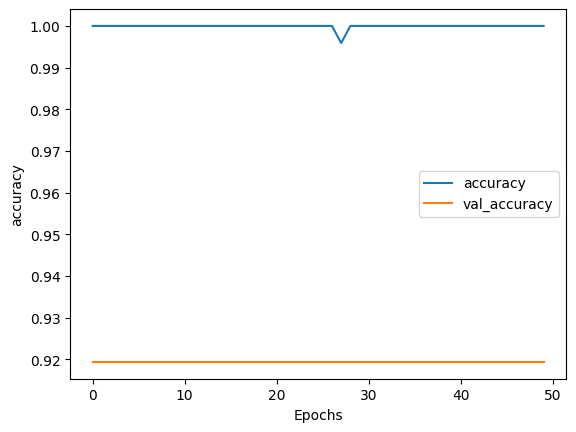

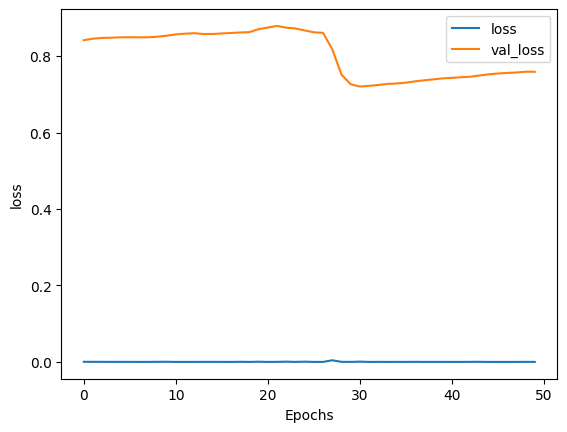

Training for 100 epochs


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_21                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,513 (658.25 KB)

 Trainable params: 168,513 (658.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 9.8007e-05 - val_accuracy: 0.9194 - val_loss: 0.7598
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.1437e-05 - val_accuracy: 0.9194 - val_loss: 0.7616
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6858e-04 - val_accuracy: 0.9194 - val_loss: 0.7647
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.1269e-05 - val_accuracy: 0.9194 - val_loss: 0.7665
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0232e-04 - val_accuracy: 0.9194 - val_loss: 0.7689
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2590e-04 - val_accuracy: 0.9194 - val_loss: 0.7726
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7175e-04 - val_accuracy: 0.9194 - val_loss: 0.7753
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0345e-04 - val_acc

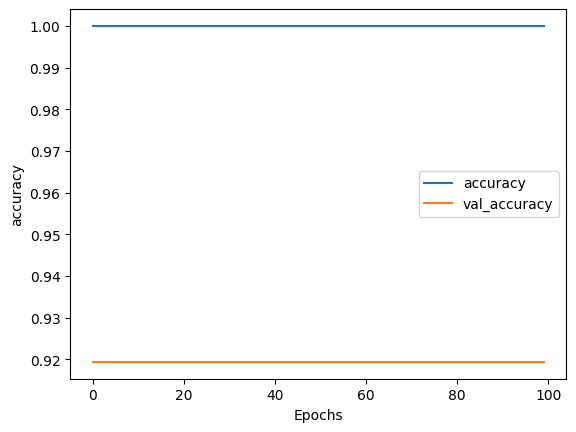

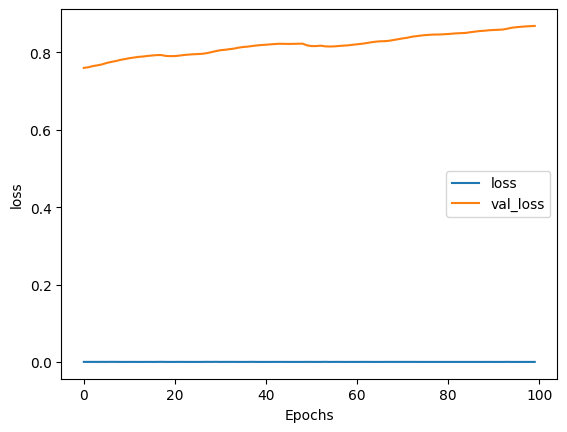

In [62]:
for epoch in epochs:
    print(f"Training for {epoch} epochs")
    model_bilstm = Sequential()
    model_bilstm.add(Bidirectional(LSTM(64, return_sequences=False), input_shape=(1, 256)))  # single time step
    model_bilstm.add(Dropout(0.2))
    model_bilstm.add(Dense(32, activation='relu'))
    model_bilstm.add(Dropout(0.2))
    model_bilstm.add(Dense(1, activation='sigmoid'))  # binary classification  

    model_bilstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_bilstm.summary()  
    history = model.fit(X_train, y_train, epochs=epoch, batch_size=32, validation_data=(X_test, y_test))
    
    # Evaluate the model
    model_bilstm.evaluate(X_test, y_test)
    evaluate_model(model, X_test, y_test)
    
    # Plot the training history
    # plot_history(history)
    # plt.show()
    plot_graphs(history, 'accuracy')
    plot_graphs(history, 'loss')
    
    # Save the model
    model.save(f'bilstm_{epoch}_up.h5')

Training for 10 epochs


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_22                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,513 (658.25 KB)

 Trainable params: 168,513 (658.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.4708 - loss: 0.6986 - val_accuracy: 0.5161 - val_loss: 0.6886
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7329 - loss: 0.6682 - val_accuracy: 0.5806 - val_loss: 0.6836
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8183 - loss: 0.6583 - val_accuracy: 0.5484 - val_loss: 0.6788
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8269 - loss: 0.6399 - val_accuracy: 0.5484 - val_loss: 0.6742
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9003 - loss: 0.6147 - val_accuracy: 0.5806 - val_loss: 0.6697
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9565 - loss: 0.5947 - val_accuracy: 0.5806 - val_loss: 0.6634
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9248 - loss: 0.5702 - val_accuracy: 0.5806 - val_loss: 0.6559
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9166 - loss: 0.5359 - val_accuracy: 0.6129 - val_loss: 0.6472


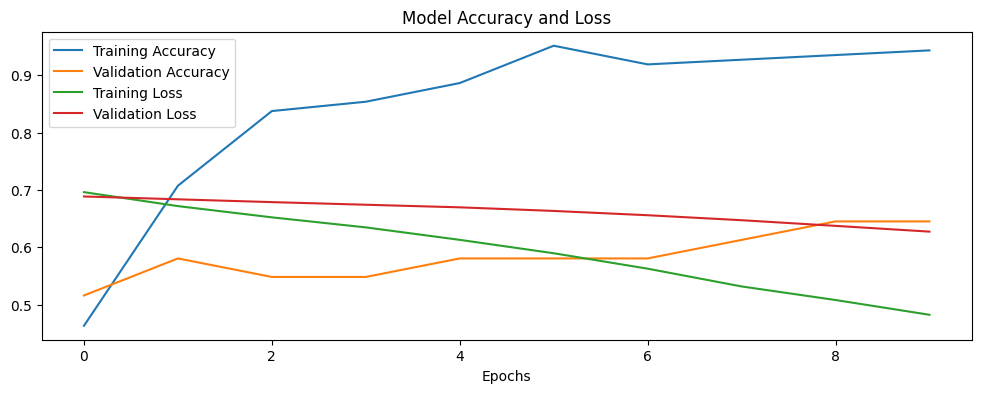

Training for 50 epochs


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_23                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_77 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,513 (658.25 KB)

 Trainable params: 168,513 (658.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.5573 - loss: 0.6863 - val_accuracy: 0.5484 - val_loss: 0.6919
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6119 - loss: 0.6708 - val_accuracy: 0.6452 - val_loss: 0.6877
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8072 - loss: 0.6587 - val_accuracy: 0.7742 - val_loss: 0.6822
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8205 - loss: 0.6425 - val_accuracy: 0.7742 - val_loss: 0.6763
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8974 - loss: 0.6236 - val_accuracy: 0.7419 - val_loss: 0.6702
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9482 - loss: 0.6058 - val_accuracy: 0.7419 - val_loss: 0.6632
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9598 - loss: 0.5763 - val_accuracy: 0.7742 - val_loss: 0.6556
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9482 - loss: 0.5625 - val_accuracy: 0.7742 - val_loss: 0.6479


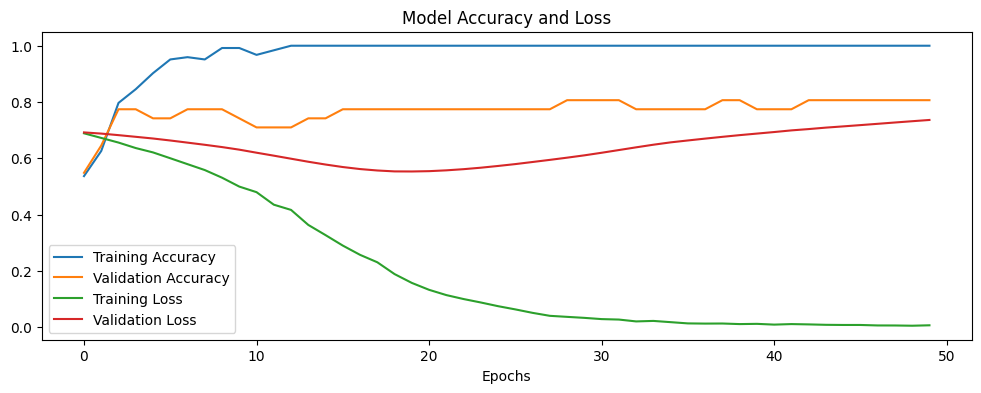

Training for 100 epochs


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_24                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,513 (658.25 KB)

 Trainable params: 168,513 (658.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.5227 - loss: 0.6928 - val_accuracy: 0.5806 - val_loss: 0.6837
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6132 - loss: 0.6697 - val_accuracy: 0.6452 - val_loss: 0.6789
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7471 - loss: 0.6507 - val_accuracy: 0.6452 - val_loss: 0.6740
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7976 - loss: 0.6258 - val_accuracy: 0.6452 - val_loss: 0.6697
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8600 - loss: 0.6071 - val_accuracy: 0.6774 - val_loss: 0.6637
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8575 - loss: 0.5879 - val_accuracy: 0.7097 - val_loss: 0.6567
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8861 - loss: 0.5795 - val_accuracy: 0.6452 - val_loss: 0.6479
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8891 - loss: 0.5465 - val_accuracy: 0.7097 - val_loss:

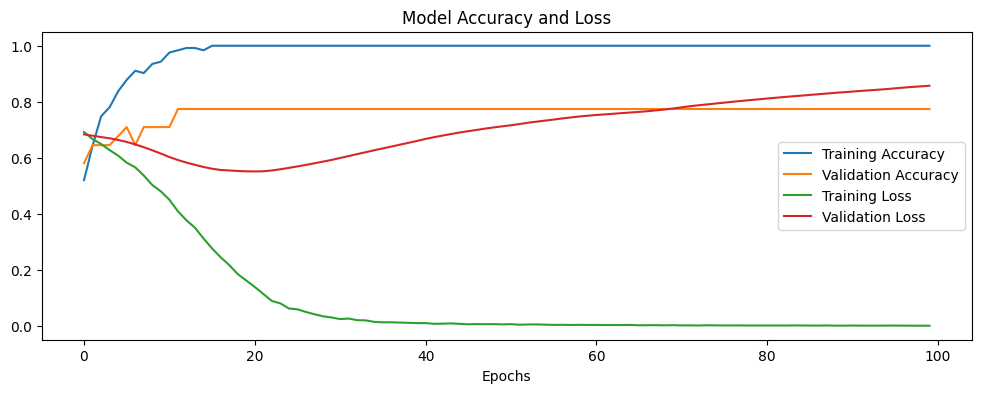

In [63]:
for epoch in epochs:
    print(f"Training for {epoch} epochs")
    model_bilstm = Sequential()
    model_bilstm.add(Bidirectional(LSTM(64, return_sequences=False), input_shape=(1, 256)))  # single time step
    model_bilstm.add(Dropout(0.2))
    model_bilstm.add(Dense(32, activation='relu'))
    model_bilstm.add(Dropout(0.2))
    model_bilstm.add(Dense(1, activation='sigmoid'))  # binary classification  

    model_bilstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_bilstm.summary()
    
    history = model_bilstm.fit(X_train77, y_train77, epochs=epoch, batch_size=32, validation_data=(X_test77, y_test77))
    # Evaluate the model
    evaluate_model(model_bilstm, X_test77, y_test77)
    # Plot the training history
    plot_history(history)
    plt.show()

Training for 10 epochs


Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_25                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_81 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,513 (658.25 KB)

 Trainable params: 168,513 (658.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5175 - loss: 0.6898 - val_accuracy: 0.5000 - val_loss: 0.6865
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7631 - loss: 0.6530 - val_accuracy: 0.5405 - val_loss: 0.6859
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8539 - loss: 0.6065 - val_accuracy: 0.5676 - val_loss: 0.6858
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9278 - loss: 0.5736 - val_accuracy: 0.5946 - val_loss: 0.6853
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9095 - loss: 0.5246 - val_accuracy: 0.6216 - val_loss: 0.6871
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9338 - loss: 0.4784 - val_accuracy: 0.6351 - val_loss: 0.6930
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9522 - loss: 0.4133 - val_accuracy: 0.6351 - val_loss: 0.7041
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9609 - loss: 0.3557 - val_accuracy: 0.6486 - val_loss: 0.7229
Epoch 9

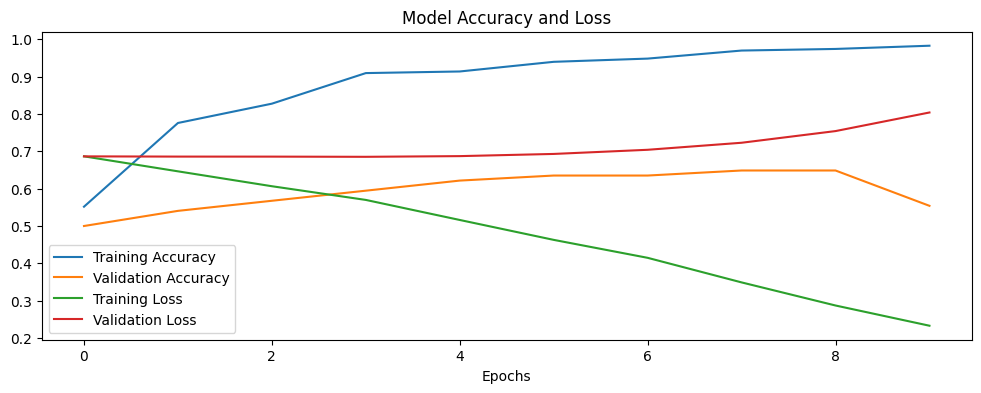

Training for 50 epochs


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_26                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_83 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,513 (658.25 KB)

 Trainable params: 168,513 (658.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5358 - loss: 0.6909 - val_accuracy: 0.4865 - val_loss: 0.6950
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7500 - loss: 0.6538 - val_accuracy: 0.4865 - val_loss: 0.6948
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7959 - loss: 0.6267 - val_accuracy: 0.5270 - val_loss: 0.6959
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9012 - loss: 0.5779 - val_accuracy: 0.5405 - val_loss: 0.6968
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9323 - loss: 0.5350 - val_accuracy: 0.5405 - val_loss: 0.6999
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9407 - loss: 0.4788 - val_accuracy: 0.5541 - val_loss: 0.7069
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9463 - loss: 0.4222 - val_accuracy: 0.5405 - val_loss: 0.7191
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9581 - loss: 0.3622 - val_accuracy: 0.5676 - val_loss: 0.7393
Epoch 9

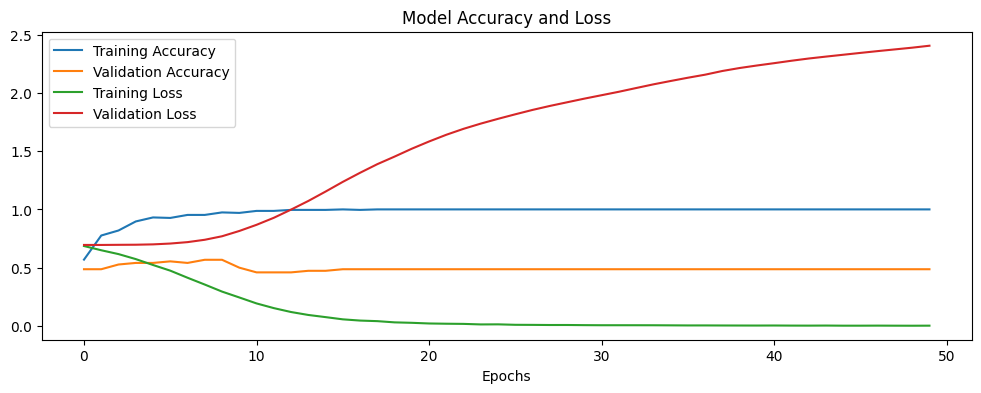

Training for 100 epochs


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_27                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_84 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_85 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,513 (658.25 KB)

 Trainable params: 168,513 (658.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5374 - loss: 0.6909 - val_accuracy: 0.6757 - val_loss: 0.6855
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8025 - loss: 0.6568 - val_accuracy: 0.5811 - val_loss: 0.6873
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8925 - loss: 0.6279 - val_accuracy: 0.5541 - val_loss: 0.6886
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9064 - loss: 0.6036 - val_accuracy: 0.5541 - val_loss: 0.6888
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9453 - loss: 0.5575 - val_accuracy: 0.5676 - val_loss: 0.6894
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9456 - loss: 0.5207 - val_accuracy: 0.5541 - val_loss: 0.6934
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9495 - loss: 0.4594 - val_accuracy: 0.4865 - val_loss: 0.7013
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9598 - loss: 0.4164 - val_accuracy: 0.5000 - val_loss: 0.7218

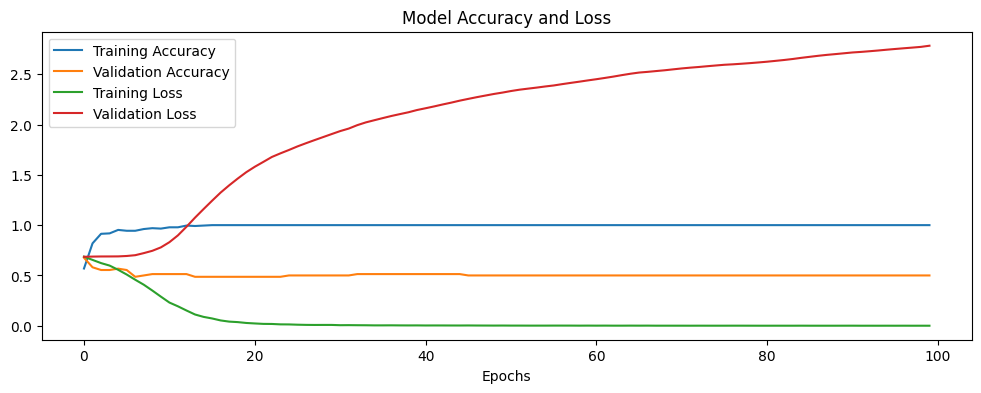

In [64]:
for e in epochs:
    print(f"Training for {e} epochs")
    model_bilstm = Sequential()
    model_bilstm.add(Bidirectional(LSTM(64, return_sequences=False), input_shape=(1, 256)))  # single time step
    model_bilstm.add(Dropout(0.2))
    model_bilstm.add(Dense(32, activation='relu'))
    model_bilstm.add(Dropout(0.2))
    model_bilstm.add(Dense(1, activation='sigmoid'))  # binary classification  

    model_bilstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_bilstm.summary()
    
    history = model_bilstm.fit(X_train2, y_train2, epochs=e, batch_size=32, validation_data=(X_test2, y_test2))
    
    # Evaluate the model
    evaluate_model(model_bilstm, X_test2, y_test2)
    
    # Plot the training history
    plot_history(history)
    plt.show()

Training for 10 epochs


Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_28                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_86 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_87 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,513 (658.25 KB)

 Trainable params: 168,513 (658.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.4540 - loss: 0.6979 - val_accuracy: 0.5000 - val_loss: 0.6982
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6296 - loss: 0.6726 - val_accuracy: 0.5556 - val_loss: 0.6982
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6443 - loss: 0.6688 - val_accuracy: 0.6111 - val_loss: 0.6975
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7686 - loss: 0.6589 - val_accuracy: 0.6111 - val_loss: 0.6964
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8865 - loss: 0.6370 - val_accuracy: 0.6111 - val_loss: 0.6960
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8865 - loss: 0.6361 - val_accuracy: 0.6111 - val_loss: 0.6958
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9393 - loss: 0.6229 - val_accuracy: 0.6111 - val_loss: 0.6958
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.6154 - val_accuracy: 0.6111 - val_loss: 0.6958

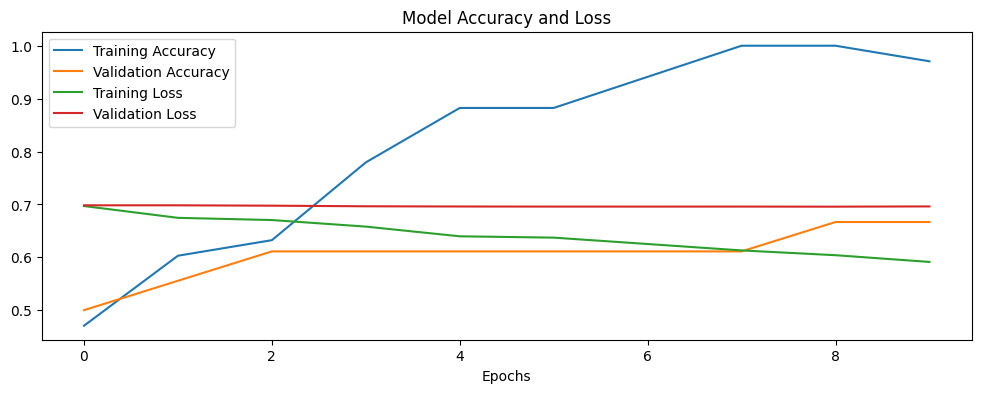

Training for 50 epochs


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_29                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_89 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,513 (658.25 KB)

 Trainable params: 168,513 (658.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.4545 - loss: 0.6977 - val_accuracy: 0.6111 - val_loss: 0.6844
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6742 - loss: 0.6791 - val_accuracy: 0.6111 - val_loss: 0.6845
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8258 - loss: 0.6644 - val_accuracy: 0.6111 - val_loss: 0.6844
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8215 - loss: 0.6558 - val_accuracy: 0.5556 - val_loss: 0.6843
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8713 - loss: 0.6414 - val_accuracy: 0.5556 - val_loss: 0.6843
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8865 - loss: 0.6408 - val_accuracy: 0.5556 - val_loss: 0.6837
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9125 - loss: 0.6262 - val_accuracy: 0.6111 - val_loss: 0.6831
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9584 - loss: 0.6149 - val_accuracy: 0.6667 - val_loss: 0.6826

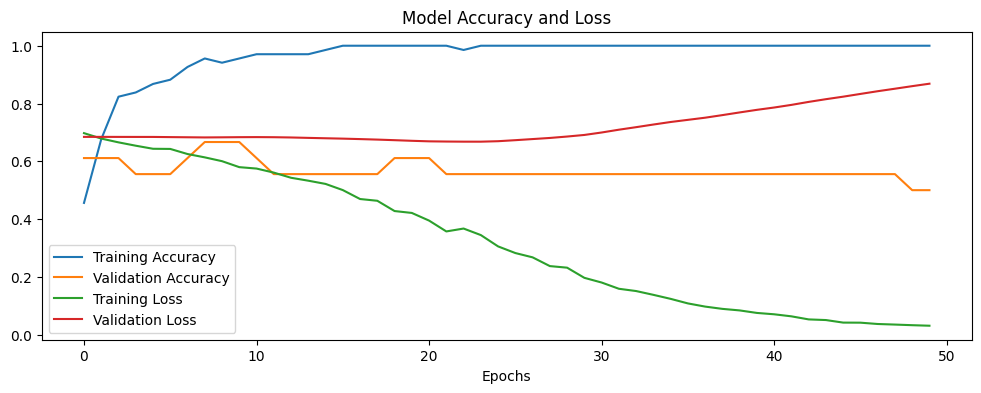

Training for 100 epochs


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_30                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_90 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_91 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,513 (658.25 KB)

 Trainable params: 168,513 (658.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.5005 - loss: 0.6951 - val_accuracy: 0.4444 - val_loss: 0.6926
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5641 - loss: 0.6815 - val_accuracy: 0.5000 - val_loss: 0.6928
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6781 - loss: 0.6690 - val_accuracy: 0.5000 - val_loss: 0.6925
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8371 - loss: 0.6496 - val_accuracy: 0.5000 - val_loss: 0.6927
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8596 - loss: 0.6450 - val_accuracy: 0.4444 - val_loss: 0.6926
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9285 - loss: 0.6312 - val_accuracy: 0.4444 - val_loss: 0.6926
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8635 - loss: 0.6077 - val_accuracy: 0.5000 - val_loss: 0.6926
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9281 - loss: 0.6058 - val_accuracy: 0.5000 - val_loss

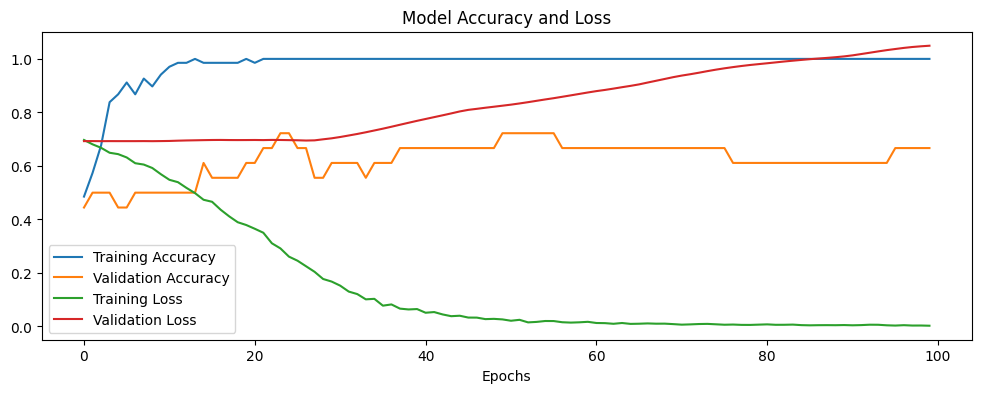

In [65]:
for epoch in epochs:
    print(f"Training for {epoch} epochs")
    model_bilstm = Sequential()
    model_bilstm.add(Bidirectional(LSTM(64, return_sequences=False), input_shape=(1, 256)))  # single time step
    model_bilstm.add(Dropout(0.2))
    model_bilstm.add(Dense(32, activation='relu'))
    model_bilstm.add(Dropout(0.2))
    model_bilstm.add(Dense(1, activation='sigmoid'))  # binary classification
    
    model_bilstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_bilstm.summary()  
    
    history = model_bilstm.fit(Xd_train, yd_train, epochs=epoch, batch_size=32, validation_data=(Xd_test, yd_test))
    # Evaluate the model
    evaluate_model(model_bilstm, Xd_test, yd_test)
    # Plot the training history
    plot_history(history)
    plt.show()

Training for 10 epochs
Epoch 1/10


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.1035e-05 - val_accuracy: 1.0000 - val_loss: 1.8093e-06
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 2.6547e-05 - val_accuracy: 1.0000 - val_loss: 1.8052e-06
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 2.0648e-05 - val_accuracy: 1.0000 - val_loss: 1.8016e-06
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 9.7312e-06 - val_accuracy: 1.0000 - val_loss: 1.7987e-06
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 1.8921e-05 - val_accuracy: 1.0000 - val_loss: 1.7958e-06
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 4.2708e-05 - val_accuracy: 1.0000 - val_loss: 1.7935e-06
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 3.4283e-05 - val_accuracy: 1.0000 - val_loss: 1.7918e-06
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 1.79

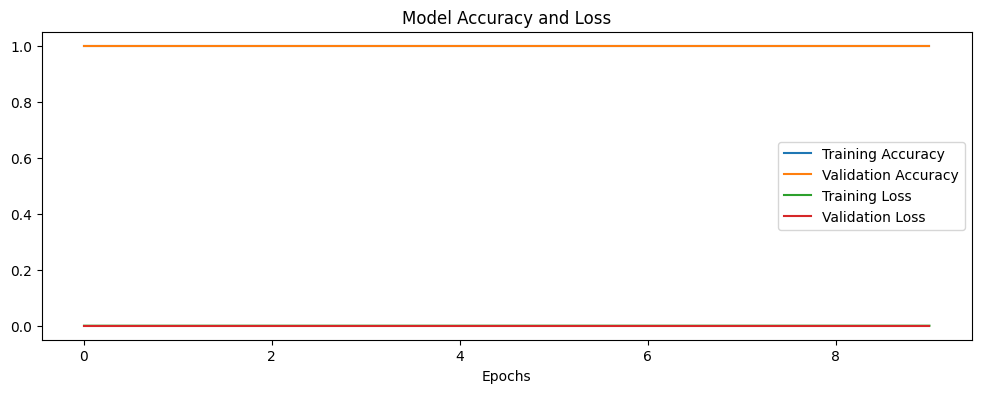

Training for 50 epochs
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 3.5346e-05 - val_accuracy: 1.0000 - val_loss: 1.7843e-06
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 8.8840e-05 - val_accuracy: 1.0000 - val_loss: 1.7819e-06
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 2.0619e-05 - val_accuracy: 1.0000 - val_loss: 1.7791e-06
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 1.8391e-05 - val_accuracy: 1.0000 - val_loss: 1.7765e-06
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 2.8184e-05 - val_accuracy: 1.0000 - val_loss: 1.7739e-06
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 9.0764e-05 - val_accuracy: 1.0000 - val_loss: 1.7701e-06
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 2.3237e-05 - val_accuracy: 1.0000 - val_loss: 1.7662e-06
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/st

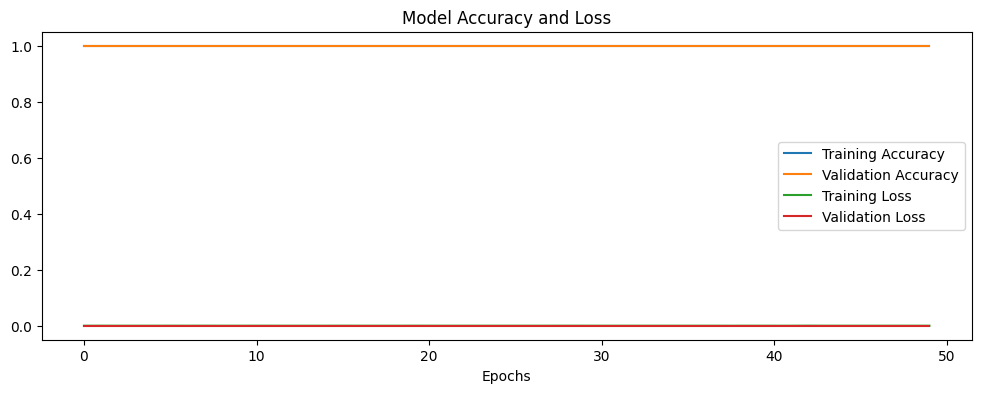

Training for 100 epochs
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 3.2098e-05 - val_accuracy: 1.0000 - val_loss: 1.6240e-06
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 3.4972e-05 - val_accuracy: 1.0000 - val_loss: 1.6209e-06
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 2.8805e-05 - val_accuracy: 1.0000 - val_loss: 1.6182e-06
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 3.4514e-05 - val_accuracy: 1.0000 - val_loss: 1.6155e-06
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 1.7340e-04 - val_accuracy: 1.0000 - val_loss: 1.6101e-06
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 9.6647e-05 - val_accuracy: 1.0000 - val_loss: 1.6054e-06
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 3.1946e-05 - val_accuracy: 1.0000 - val_loss: 1.6016e-06
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0

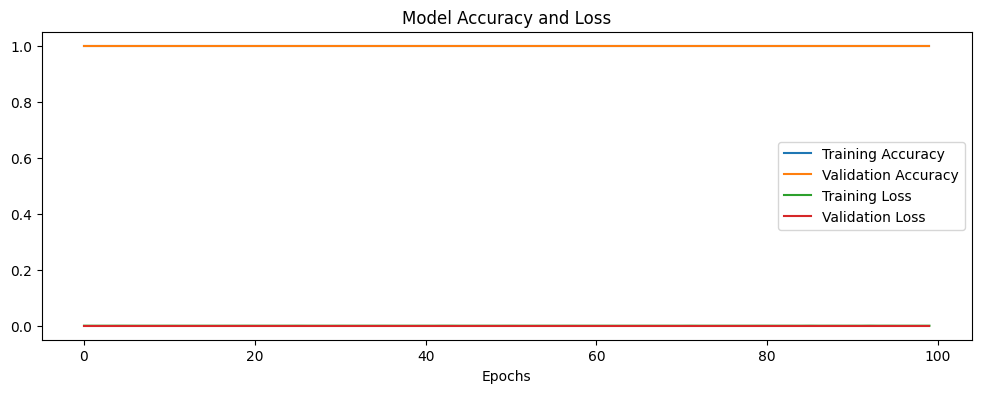

In [66]:
for epoch in epochs:
    print(f"Training for {epoch} epochs")
    history = model.fit(Xd_train2, yd_train2, epochs=epoch, batch_size=32, validation_data=(Xd_test2, yd_test2))
    # Evaluate the model
    evaluate_model(model, Xd_test2, yd_test2)
    # Plot the training history
    plot_history(history)
    plt.show()  

# List of Models

<!-- make a table of number of epochs, dataset, number of gru layers, number of dense layer units, input shape, batch size, callbacks, rergularization, optimizer, loss function, accuracy and precision -->

| Number of Epochs | Dataset Type                     | GRU Layers | Dense Layer Units | Input Shape | Batch Size | Callbacks | Regularization | Optimizer | Loss Function | Accuracy | Precision |
|------------------|----------------------------------|------------|-------------------|-------------|------------|-----------|----------------|-----------|-----------|-------------|----------|
| 10               | Upsampled Balanced Dataset       || 2          | 64                | (None, 100, 13) || 32         | EarlyStopping, ModelCheckpoint   | L2(0.01) | Adam      | SparseCategoricalCrossentropy | 0.85        | 0.80     |
| 50               | Upsampled Balanced Dataset       || 2          | 64                | (None, 100, 13) || 32         | EarlyStopping, ModelCheckpoint   | L2(0.01) | Adam      | SparseCategoricalCrossentropy | | 0.90        | 0.85     |
| 100              | Upsampled Balanced Dataset       || 2          | 64                | (None, 100, 13                